In [1]:
import time
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class Conv2DBatchNormReLU(tf.keras.layers.Layer):
    def __init__(self, filters, l2=1e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            use_bias=False,
            kernel_initializer=tf.keras.initializers.HeUniform(),
            kernel_regularizer=tf.keras.regularizers.l2(l2),
        )
        self.batch_norm = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9,
            beta_regularizer=tf.keras.regularizers.l2(l2),
            gamma_regularizer=tf.keras.regularizers.l2(l2)
        )

    def call(self, inputs, training=False):
        x = self.conv2d(inputs)
        x = self.batch_norm(x, training=training)
        return tf.nn.relu(x)


class ResNet9Block(tf.keras.layers.Layer):
    def __init__(self, filters, l2=1e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv_bn_relu_1 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.conv_bn_relu_2 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.downsample = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=1,
            strides=2,
            padding='SAME',
            use_bias=False,
            kernel_regularizer=tf.keras.regularizers.l2(l2)
        )
        self.batch_norm = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9,
            beta_regularizer=tf.keras.regularizers.l2(l2),
            gamma_regularizer=tf.keras.regularizers.l2(l2)
        )
        self.max_pool2d = tf.keras.layers.MaxPool2D(pool_size=2)

    def call(self, inputs, training=False):
        shortcut = self.downsample(inputs)
        shortcut = self.batch_norm(shortcut, training=training)

        x = self.conv_bn_relu_1(inputs, training=training)
        x = self.max_pool2d(x)
        x = self.conv_bn_relu_2(x, training=training)

        return tf.nn.relu(x + shortcut)


# Load the model with custom layers
model = tf.keras.models.load_model(
    "/content/CIFAR-TUNED-RESNET9-AUG.keras",
    custom_objects={
        "Conv2DBatchNormReLU": Conv2DBatchNormReLU,
        "ResNet9Block": ResNet9Block
    }
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'conv2d_batch_norm_re_lu', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'res_net9_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'conv2d_batch_norm_re_lu_3'

In [6]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


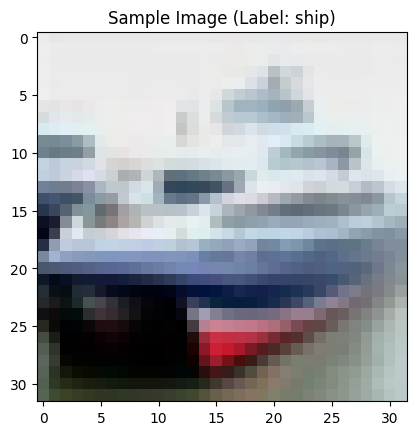

In [12]:
ind=1
sample_image = X_test[1]
plt.imshow(sample_image)
plt.title(f"Sample Image (Label: {class_labels[y_test[15][0]]})")
plt.show()

In [13]:
sample_image = np.expand_dims(sample_image, axis=0)
sample_image = sample_image.astype('float32') / 255.0

In [14]:
def measure_latency(model, sample_image, device='cpu'):
    with tf.device(device):
        start_time = time.time()
        predictions = model.predict(sample_image)
        end_time = time.time()

    latency = end_time - start_time
    return predictions, latency

In [16]:
predictions, cpu_latency = measure_latency(model, sample_image, device='/CPU:0')
predicted_label = np.argmax(predictions)
print(f"Predicted label (CPU): {class_labels[predicted_label]}")
print(f"Latency on CPU: {cpu_latency:.6f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted label (CPU): ship
Latency on CPU: 0.155948 seconds
